<h1>Dog breed classification</h1>

**ID: AI-0007<br>
Submission date: 16-1-2018**
<br><br>

# INTRODUCTION

The objective of this assignment is to classify different type of Dog breed from their images.

In [1]:
import numpy as np 
import pandas as pd 
import keras
from keras.applications import *
from keras.applications.vgg19 import *
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.optimizers import SGD
import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

Using TensorFlow backend.


Let's read the necessary files

In [2]:
df_train = pd.read_csv('labels.csv')
df_test = pd.read_csv('sample_submission.csv')

now map the lables with numbers.

In [3]:
targets_series = pd.Series(df_train['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [4]:
im_size = 139
x_train = []
y_train = []
x_test = []

prepare the train df, test df and the lables for train data

In [5]:
i = 0 
for f, breed in tqdm(df_train.values):
    img = cv2.imread('train/{}.jpg'.format(f))
    label = one_hot_labels[i]
    x_train.append(cv2.resize(img, (im_size, im_size)))
    y_train.append(label)
    i += 1

100%|███████████████████████████████████████████████████████████████████████████| 10222/10222 [00:32<00:00, 318.97it/s]


In [6]:
for f in tqdm(df_test['id'].values):
    img = cv2.imread('test/{}.jpg'.format(f))
    x_test.append(cv2.resize(img, (im_size, im_size)))

100%|███████████████████████████████████████████████████████████████████████████| 10357/10357 [01:15<00:00, 136.55it/s]


As neural network prefer normalized data, so Let's normalaiz data.

In [7]:
# Normalization
y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.
x_test  = np.array(x_test, np.float32) / 255.

print(x_train_raw.shape)
print(y_train_raw.shape)
print(x_test.shape)

(10222, 139, 139, 3)
(10222, 120)
(10357, 139, 139, 3)


In [9]:
num_class = y_train_raw.shape[1]

Let's split the data into train and validation set to observe how model is working.

In [10]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train_raw, y_train_raw, test_size=0.3, random_state=1)

Now all my necessary materials are prepaired, Let's create a model for predict the images. I use InceptionV3 pre-trained model to predict the images.

In [20]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

predictions = Dense(num_class, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

saved_path='weights_inceptionv3.h5'
model_checkpoint = ModelCheckpoint(filepath=saved_path, monitor='val_loss', verbose=1,
                                   save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.5, patience=5, verbose=1, mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.001, mode='auto')

callback_list = [model_checkpoint, reduce_lr, early_stop]


Let's train my model. as i saved my weight in toa .h5 file, and if that file exist in my directory, than no need to feed the model again.

In [21]:
if os.path.isfile(saved_path):
    print("weight already exist")
else:
    model.fit(X_train, Y_train, epochs=15, validation_data=(X_valid, Y_valid), verbose=1 , callbacks = callback_list)

weight already exist


In [22]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_3
1 conv2d_189
2 batch_normalization_189
3 activation_189
4 conv2d_190
5 batch_normalization_190
6 activation_190
7 conv2d_191
8 batch_normalization_191
9 activation_191
10 max_pooling2d_9
11 conv2d_192
12 batch_normalization_192
13 activation_192
14 conv2d_193
15 batch_normalization_193
16 activation_193
17 max_pooling2d_10
18 conv2d_197
19 batch_normalization_197
20 activation_197
21 conv2d_195
22 conv2d_198
23 batch_normalization_195
24 batch_normalization_198
25 activation_195
26 activation_198
27 average_pooling2d_19
28 conv2d_194
29 conv2d_196
30 conv2d_199
31 conv2d_200
32 batch_normalization_194
33 batch_normalization_196
34 batch_normalization_199
35 batch_normalization_200
36 activation_194
37 activation_196
38 activation_199
39 activation_200
40 mixed0
41 conv2d_204
42 batch_normalization_204
43 activation_204
44 conv2d_202
45 conv2d_205
46 batch_normalization_202
47 batch_normalization_205
48 activation_202
49 activation_205
50 average_pooling2d_20
51 conv2d_201
52 

In [ ]:
#does not work.
'''def layer_to_visualize(layer):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img_to_visualize)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    n = convolutions.shape[0]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(len(convolutions)):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[i], cmap='gray')'''

Let's predict the images.

In [23]:
preds = model.predict(x_test, verbose=1)

10357/10357 [==============================] - ETA: 16:3 - ETA: 8:4 - ETA: 6: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 -

In [24]:
sub = pd.DataFrame(preds)
# Set column names to those generated by the one-hot encoding earlier
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
sub.insert(0, 'id', df_test['id'])
sub.head(5)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.002691,0.004678,0.000518,0.236464,0.000445,0.000872,0.000289,0.002951,0.000682,...,0.013665,0.001567,0.001939,0.008842,0.000094,0.016364,0.002336,0.001210,0.023289,0.004539
1,00102ee9d8eb90812350685311fe5890,0.003830,0.003885,0.001322,0.002855,0.001445,0.000457,0.000672,0.050746,0.000081,...,0.028188,0.011017,0.018739,0.055458,0.000020,0.048477,0.000299,0.000831,0.027378,0.002799
2,0012a730dfa437f5f3613fb75efcd4ce,0.001082,0.008616,0.000383,0.005200,0.000208,0.003818,0.000185,0.002870,0.000403,...,0.002874,0.001972,0.000180,0.012863,0.000054,0.003132,0.000855,0.000619,0.001419,0.002965
3,001510bc8570bbeee98c8d80c8a95ec1,0.000774,0.008789,0.007571,0.051240,0.001926,0.002509,0.001261,0.027909,0.000511,...,0.015767,0.002704,0.000480,0.014923,0.000042,0.050657,0.008492,0.001933,0.005472,0.015309
4,001a5f3114548acdefa3d4da05474c2e,0.001659,0.006776,0.000422,0.012198,0.013473,0.004485,0.000762,0.004640,0.006250,...,0.023436,0.017251,0.000375,0.016678,0.000072,0.009807,0.002698,0.007650,0.162886,0.000518


In [25]:
sub.to_csv('dog_result_inceptionv3.csv',index = False)

# CONCLUSION

The idea of this project was to get introduced to pre-trained CNN models and how it can be implemented. With even more fine-tuning of the data better resul can be achieved.

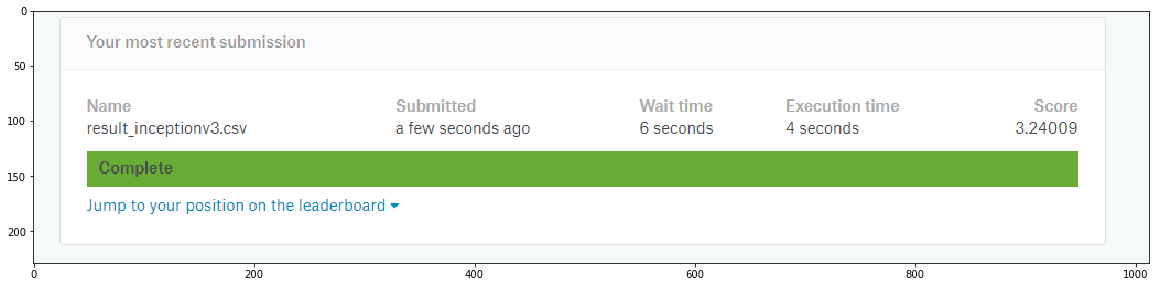

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig = plt.gcf()
fig.set_size_inches(20, 10)
img=mpimg.imread('result.png')
imgplot = plt.imshow(img)
plt.show()